# Python SDK Tutorial: Local Compute Flow

In this notebook tutorial, we'll use TruEra's Python SDK to create add data and a model using the _local compute_ flow. This is the access provided with _self-service TruEra Diagnostics_.

### What we'll cover ☑️
* Create a local project with a model and data splits.
* Compare performance and explanations across for your model.
* Upload our local project to a remote deployment.

## Step 1: Connect to TruEra endpoint
This is a tutorial for a basic flow using the SDK's _local environment_. All artifacts and computations will first only exist on your local machine until they are uploaded to your TruEra deployment.

#### What do I need to connect to my TruEra deployment?
* TruEra URL. For free users, thsi will be https://app.truera.net
* Your Authentication Token (token retrieval instructions below)

You can retrieve your auth token at this link: 

https://app.truera.net/home/p?modal=workspaceSettings&selectedTab=authentication

Doing so will open a browser that may ask you to log in, and then display a pop-up window with a button named "Generate Credentials". Click that button.

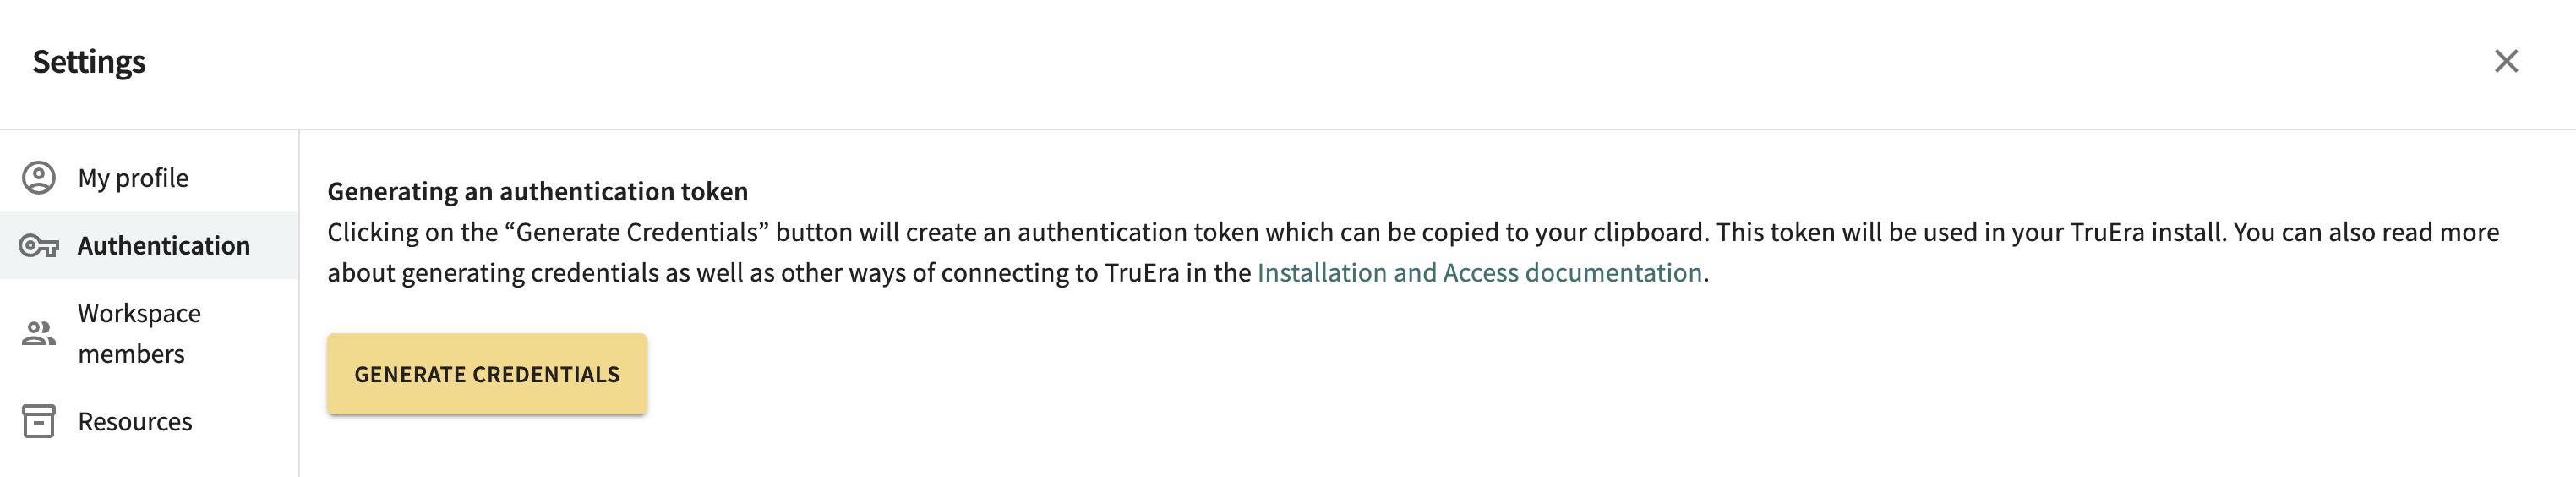

After clicking "Generate Credentials", you will get a pop-up with your authentication token. You can simply click the copy icon to add it to your clipboard. After you've done so, just add it to the cell below along with your TruEra URL.

In [ ]:
# FILL ME!

TRUERA_URL = "https://app.truera.net"
AUTH_TOKEN = ""

### Install a few required packages from pypi. This may take a few minutes.

In [ ]:
! pip install --upgrade truera
! pip install --upgrade shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 860.3/860.3 KB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.6/498.6 KB 43.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 39.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.4/211.4 KB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 KB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 KB 5.2 MB/s eta 0:00:00
  Created wheel for crontab: filename=crontab-0.23.0-py3-none-any.whl size=20555 sha256=4131ca79d90270a938ad25e0d0c5f6f8e2e39bfd2d0b6f49a213529c368df1bc
  Stored in directory: /root/.cache/pip/wheels/07/8b/dc/bb81817e3ad7788860d84564033941c5cec213fcfc572bc588
  Created wheel for mpmath: filename=mpmath-0.19-py3-none-any.whl size=519

In [ ]:
from truera.client.truera_workspace import TrueraWorkspace
from truera.client.truera_authentication import TokenAuthentication

auth = TokenAuthentication(AUTH_TOKEN)
tru = TrueraWorkspace(TRUERA_URL, auth, ignore_version_mismatch=True)

## Step 2: Download sample data
Here we'll use data from scikit-learn's California housing dataset. This can be installed via the `sklearn.datasets` module.

In [ ]:
# Retrieve the data.

import pandas as pd
from sklearn.datasets import fetch_california_housing

data_bunch = fetch_california_housing()
XS_ALL = pd.DataFrame(data=data_bunch["data"], columns=data_bunch["feature_names"])
ids = [f"point_{i}" for i in range(len(XS_ALL))]
XS_ALL["id"] = ids
YS_ALL = pd.DataFrame(data = data_bunch["target"], columns=["target"])
YS_ALL["id"] = ids

In [ ]:
# Create train and test data splits.

from sklearn.model_selection import train_test_split

XS_TRAIN, XS_TEST, YS_TRAIN, YS_TEST = train_test_split(XS_ALL, YS_ALL, test_size=100)

## Step 3: Create a local project

In [ ]:
tru.set_environment("local")
project_name = "California-Housing"
tru.add_project(project_name, score_type="regression")

## Step 4: Add the data collection and data split
Here we're adding data via simple `pd.DataFrame`s.

In [ ]:
tru.add_data_collection("sklearn_data")
tru.add_data_split(
    data_split_name="all",
    pre_data=XS_ALL,
    label_data=YS_ALL,
    id_col_name="id",
    split_type="all")
tru.add_data_split(
    data_split_name="train",
    pre_data=XS_TRAIN,
    label_data=YS_TRAIN,
    id_col_name="id",
    split_type="train")
tru.add_data_split(
    data_split_name="test",
    pre_data=XS_TEST,
    label_data=YS_TEST,
    id_col_name="id",
    split_type="test")

INFO:truera.client.local.local_truera_workspace:Data collection in local environment is now set to "sklearn_data". 
INFO:truera.client.local.local_truera_workspace:Data split "all" is added to local data collection "sklearn_data", and set as the data split for the workspace context.
INFO:truera.client.local.local_truera_workspace:Data split "train" is added to local data collection "sklearn_data", and set as the data split for the workspace context.
INFO:truera.client.local.local_truera_workspace:Data split "test" is added to local data collection "sklearn_data", and set as the data split for the workspace context.


## Step 5: Train and add a boosted tree regression model

In [ ]:
# Train the model.

from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor()
gb_model.fit(XS_TRAIN.drop("id", axis = 1), YS_TRAIN.drop("id", axis = 1))

We can add the model itself via [`tru.add_python_model()`](python_sdk_reference.md#truera.client.truera_workspace.TrueraWorkspace.add_python_model), which accepts a number of out-of-the box model frameworks.

In [ ]:
# Add to TruEra workspace.

tru.add_python_model("gradient boosted", gb_model)

INFO:truera.client.local.local_truera_workspace:Model "gradient boosted" is added and associated with local data collection "sklearn_data". "gradient boosted" is set as the model for the workspace context.


In [ ]:
# View ISP.

tru.get_explainer(base_data_split="test").plot_isp(feature='HouseAge')

## Step 6: Sync local project with remote deployment

We've been creating and manipulating our project _locally_ - but how do we explore our project further using the TruEra UI or other features that are only available with a remote deployment? The easiest way is to upload the project to a remote deployment.

Syncing a local project with a remote deployment effectively uploads all artifacts and pre-computed information (such as predictions and influences) to a remote deployment. This will create (or append to) a project of the same name, with all of the data splits and models we just added!

We can upload a local project to a remote environment via [`tru.upload_project()`](https://docs.truera.com/1.33/public/python_sdk_reference/#truera.client.truera_workspace.TrueraWorkspace.upload_project). Similarly, we can download a remote project to a local environment via [`tru.download_project()`](https://docs.truera.com/1.33/public/python_sdk_reference/#truera.client.truera_workspace.TrueraWorkspace.download_project).

In [ ]:
tru.upload_project(upload_error_influences = False)

# Note that we're explicitly opting not to compute and upload error influences to optimize for ingestion speed. This is because SHAP is not optimized to compute error influences for regression models.
# Doing so will disable the "Debug" tab under Performance, and the "Contributors to Error Influence" tab under Drift.
# If you'd like to enable these pages, please remove the flag, i.e. run the method below. Please be aware that doing so will greatly increase the time required for ingestion.
# tru.upload_project()

INFO:truera.client.truera_workspace:Uploading data collection sklearn_data.
INFO:truera.client.truera_workspace:Uploading data split all.


Uploading tmp6qusnixj.parquet -- ### -- file upload complete.
Put resource done.
Uploading tmpiotygeif.parquet -- ### -- file upload complete.
Put resource done.


INFO:truera.client.remote_truera_workspace:Call to join: rowsets ['5caa2bf9-1736-40f7-b821-ad2ef51d25df', '8ed4a7b1-5d72-4daa-a085-047cd2613aca'] on ['id'] with default inner join.
INFO:truera.client.truera_workspace:Uploading data split train.


Uploading tmp4ahztqhy.parquet -- ### -- file upload complete.
Put resource done.
Uploading tmp5rgpqnhm.parquet -- ### -- file upload complete.
Put resource done.


INFO:truera.client.remote_truera_workspace:Call to join: rowsets ['5d8f7422-cd48-4032-a338-eb0896e59133', 'e5b39bc6-be72-4e11-a4c1-18556601f00d'] on ['id'] with default inner join.
INFO:truera.client.truera_workspace:Uploading data split test.


Uploading tmprsqrgonw.parquet -- ### -- file upload complete.
Put resource done.
Uploading tmp1is_8830.parquet -- ### -- file upload complete.
Put resource done.


INFO:truera.client.remote_truera_workspace:Call to join: rowsets ['9a081f99-9de9-478f-ba10-8a54ebbeba7c', 'c2bd094b-d108-4c4d-b042-612c9e2ed9b1'] on ['id'] with default inner join.
INFO:truera.client.remote_truera_workspace:Setting remote model context to "gradient boosted".


Uploading tmp6brofvohparquet -- ### -- file upload complete.
Put resource done.


INFO:truera.client.remote_truera_workspace:Waiting for data split to materialize...


Uploading tmpq9gu9za5parquet -- ### -- file upload complete.
Put resource done.


INFO:truera.client.remote_truera_workspace:Waiting for data split to materialize...


Uploading tmpismmjoa2parquet -- ### -- file upload complete.
Put resource done.


INFO:truera.client.remote_truera_workspace:Waiting for data split to materialize...
INFO:truera.client.truera_workspace:Influence algorithm for local project is: shap


|          | 0.000% [00:00<?]

Uploading tmpmu0m5kcmparquet -- ### -- file upload complete.
Put resource done.


INFO:truera.client.remote_truera_workspace:Waiting for data split to materialize...


Uploading tmpx9ns89guparquet -- ### -- file upload complete.
Put resource done.


INFO:truera.client.remote_truera_workspace:Waiting for data split to materialize...
INFO:truera.client.truera_workspace:Influence algorithm for local project is: shap


|          | 0.000% [00:00<?]

Uploading tmpdrndo4tgparquet -- ### -- file upload complete.
Put resource done.


INFO:truera.client.remote_truera_workspace:Waiting for data split to materialize...


Uploading tmp7ksvs5hqparquet -- ### -- file upload complete.
Put resource done.


INFO:truera.client.remote_truera_workspace:Waiting for data split to materialize...
INFO:truera.client.truera_workspace:`num_default_influences` is greater than the number of available data points for split "test". Setting to this: 100
INFO:truera.client.truera_workspace:Influence algorithm for local project is: shap


|          | 0.000% [00:00<?]

Uploading tmpevz7bcq2parquet -- ### -- file upload complete.
Put resource done.


INFO:truera.client.remote_truera_workspace:Waiting for data split to materialize...


Uploading tmp3rpra9qhparquet -- ### -- file upload complete.
Put resource done.


INFO:truera.client.remote_truera_workspace:Waiting for data split to materialize...


View the models on the platform! Once you sync to remote using the upload_project(), head over to the web application at the link below to view Influence Sensitivity Plots, use the Test Harness, check out the Model Leaderboard and more!

In [ ]:
print(TRUERA_URL + "/home/p/" + project_name)

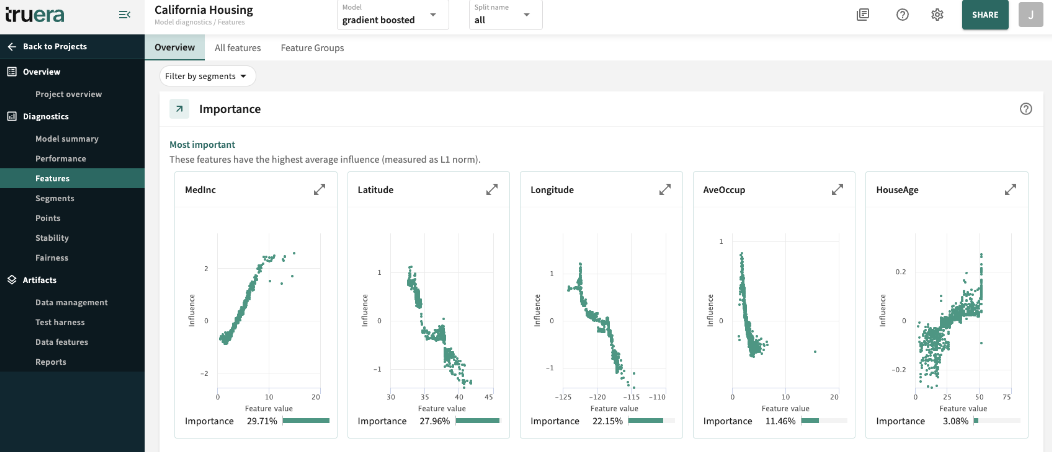